## Evaluation

In [1]:
%matplotlib inline

import csv
import os

import numpy as np
import pandas as pd
import seaborn as sn
import tensorflow as tf

from typing import List

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt

from phenotyper.leaf_count import leaf_count

In [4]:
segnet_model = tf.keras.models.load_model("saved_models/saved_segmentation_model")
reg_model = tf.keras.models.load_model("saved_models/saved_regression_model")

## Evaluation Dataset
The machine learning model was trained with an 80-10-10 split so 10% of the images from the dataset will be used to evaluate the machine learning model but also the PlantCV and OpenCV models as well

In [5]:
image_path: str = "../Leaf_Dataset/images"
mask_path: str = "../Leaf_Dataset/masks"
count_path: str = "../Leaf_Dataset/truth.csv"

images: List[str] = sorted(os.listdir(image_path))
images = [f"{image_path}/{i}" for i in images]
masks: List[str] = sorted(os.listdir(mask_path))
masks = [f"{mask_path}/{m}" for m in masks]

counts: List[int] = []
with open(count_path, "r") as truth_file:
    reader = csv.reader(truth_file)
    headings = next(reader)
    counts = [int(row[1]) for row in reader]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(images,
                                                    counts,
                                                    random_state=5,
                                                    shuffle=True,
                                                    test_size=0.20)
X_test, X_val, y_test, y_val = train_test_split(X_test,
                                                y_test,
                                                random_state=5,
                                                shuffle=True,
                                                test_size=0.50)

In [7]:
print(len(X_train))
print(len(X_test))
print(len(X_val))

7041
880
881


In [8]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

## Helper Methods

In [9]:
# Functions to flip images(50% chance)
@tf.function
def random_horizontal_flip(image, mask):
    random_num = tf.random.uniform([], 0, 1.0)
    cond_value = tf.less(random_num, 0.5)
    image = tf.cond(cond_value,
                    lambda: tf.image.flip_left_right(image),
                    lambda: image)
    mask = tf.cond(cond_value,
                   lambda: tf.image.flip_left_right(mask),
                   lambda: mask)
    return image, mask

@tf.function
def random_vertical_flip(image, mask):
    random_num = tf.random.uniform([], 0, 1.0)
    cond_value = tf.less(random_num, 0.5)
    image = tf.cond(cond_value,
                    lambda: tf.image.flip_up_down(image),
                    lambda: image)
    mask = tf.cond(cond_value,
                   lambda: tf.image.flip_up_down(mask),
                   lambda: mask)
    return image, mask

# Function to rotate images by 4 degrees
@tf.function
def rotate_image(image, mask):
    image = tfa.image.rotate(image,
                             4,
                             interpolation="NEAREST")
    mask = tfa.image.rotate(mask,
                            4,
                            interpolation="NEAREST")
    return image, mask

# Load the images and masks from paths
@tf.function
def get_images_and_counts(image_path, count):
    # Read the image path
    image = tf.io.decode_png(tf.io.read_file(image_path), channels=3)
    image = tf.image.convert_image_dtype(image, tf.float64)
    # Resizing
    image = tf.image.resize(image, [448, 448])  # Based on the values from the paper
    return image, count

# Data augmentation
@tf.function
def data_augmentation_and_mask_concatenation(image, count):
    random_number = tf.random.uniform(shape=[],
                                      maxval=5,
                                      dtype=tf.int32)
    
    #Get the mask from saved segmentation model
    image_for_segmentation = tf.image.resize(image, [224, 224])
    image_for_segmentation = tf.reshape(image_for_segmentation, [1 ,224, 224, 3])
    mask = segnet_model(image_for_segmentation, training=False)      # Return batch of 1 predicted image. Hence select the 0th element to get the prediction
    mask = tf.image.resize(mask[0], [448, 448])   # Tensorshape = [448, 448, 1]

    # ==1 then apply rotation
    if tf.equal(random_number, tf.constant(1)):
        image, mask = rotate_image(image, mask)
        
    # ==2 then apply horizontal flip
    elif tf.equal(random_number, tf.constant(1)):
        image, mask = random_horizontal_flip(image, mask)
        
    # ==3 then apply vertical flip
    elif tf.equal(random_number, tf.constant(1)):
        image, mask = random_vertical_flip(image, mask)
            
    # ==4 then apply gaussian blur
    elif tf.equal(random_number, tf.constant(1)):
        #image, mask = gaussian_blur(image, mask)
        pass # Since current environment version does not support the tf gaussian blur function
        
    # ==5 No augmentation
    else:
        pass
    
    # Concatenate the image with mask(as the 4th channel)
    combined_image = tf.concat([mask, image], axis = -1)   # Tensorshape = [448, 448, 4]

    return combined_image, count

# Function to get the image mask and concatenate with input image without data augmentation(for validation and test data)
@tf.function
def mask_concatenation(image, count):
    # Get the mask from saved segmentation model
    image_for_segmentation = tf.image.resize(image, [224, 224])
    image_for_segmentation = tf.reshape(image_for_segmentation, [1 ,224, 224, 3])
    mask = segnet_model(image_for_segmentation, training=False)      # Return batch of 1 predicted image. Hence select the 0th element to get the prediction
    mask = tf.image.resize(mask[0], [448, 448])   # Tensorshape = [448, 448, 1]

    # Concatenate the image with mask(as the 4th channel)
    combined_image = tf.concat([mask, image], axis=-1)   # Tensorshape = [448, 448, 4]

    return combined_image, count

In [14]:
val_set_images = []
val_set_count = []
counter = 0
total = len(X_val)
for image, count in zip(X_val, y_val):
    image, count = get_images_and_counts(image, count)
    image, count = mask_concatenation(image, count)
    val_set_images.append(image)
    val_set_count.append(count)
    counter += 1
    print(f"Images processed: {counter}/{total}", end="\r")

In [15]:
len(val_set_images)

881

In [16]:
#for i in range(len(X_val)):
#    X_val[i],_ = get_images_and_counts(X_val[i], 1)

val_set_images = np.array(val_set_images)
val_set_count = np.array(val_set_count)

### ML Predictions

In [ ]:
#ml_predictions = []
#for im in val_set_images:
#    ml_predictions.append(reg_model.predict(im))
ml_predictions = reg_model.predict(val_set_images)
ml_predictions = ml_predictions.reshape(ml_predictions.shape[0])

In [1]:
print(f"Predicted Leaf Count: {ml_predictions[0]}, True Leaf Count: {y_val[0]}")
#plt.imshow(X_val[0])
#plt.show()

NameError: name 'ml_predictions' is not defined

### PlantCV Predictions

In [6]:
class input_file:
    def __init__(self, in_file):
        self.input = in_file

In [7]:
model: str = "PLANTCV"
pcv_predictions: List[int] = []
pcv_count = 0
for im in X_val:
    input_file_data = input_file(im)
    pcv_count += 1
    print(f"File number: {pcv_count}")
    #print(f"Analysing file: {input_file_data.input}", end="\r")
    leaf_count_res = leaf_count(args=input_file_data,
                                model=model)
    pcv_predictions.append(leaf_count_res["count"])

File number: 1
File number: 2
File number: 3


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 4
File number: 5
File number: 6


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 7
File number: 8
File number: 9
File number: 10
File number: 11
File number: 12


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 13
File number: 14


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.


File number: 15


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 16
File number: 17
File number: 18
File number: 19
File number: 20


/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation 

File number: 21
File number: 22
File number: 23
File number: 24
File number: 25


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 26
File number: 27
File number: 28
File number: 29


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 30
File number: 31
File number: 32


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.


File number: 33


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 34
File number: 35
File number: 36
File number: 37


/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation 

File number: 38
File number: 39


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.


File number: 40
File number: 41
File number: 42
File number: 43
File number: 44


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 45
File number: 46
File number: 47
File number: 48
File number: 49


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 50
File number: 51
File number: 52


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 53
File number: 54
File number: 55
File number: 56
File number: 57
File number: 58


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 59
File number: 60
File number: 61
File number: 62
File number: 63


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.


File number: 64


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 65
File number: 66


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.


File number: 67


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 68
File number: 69
File number: 70


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 71
File number: 72


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 73
File number: 74
File number: 75
File number: 76


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 77
File number: 78
File number: 79
File number: 80
File number: 81


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 82
File number: 83
File number: 84
File number: 85
File number: 86
File number: 87
File number: 88


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 89
File number: 90


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 91
File number: 92
File number: 93
File number: 94


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 95
File number: 96
File number: 97


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 98
File number: 99
File number: 100
File number: 101
File number: 102
File number: 103


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 104
File number: 105
File number: 106
File number: 107


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 108
File number: 109
File number: 110
File number: 111


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 112
File number: 113


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 114
File number: 115
File number: 116
File number: 117
File number: 118
File number: 119


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 120
File number: 121
File number: 122
File number: 123


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 124
File number: 125
File number: 126


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 127
File number: 128
File number: 129


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 130
File number: 131
File number: 132
File number: 133


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 134
File number: 135
File number: 136
File number: 137
File number: 138
File number: 139


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 140
File number: 141


/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation 

File number: 142
File number: 143
File number: 144
File number: 145


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 146
File number: 147
File number: 148
File number: 149
File number: 150
File number: 151
File number: 152


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 153
File number: 154
File number: 155
File number: 156


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 157
File number: 158
File number: 159


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 160
File number: 161
File number: 162
File number: 163
File number: 164
File number: 165


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.


File number: 166


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 167
File number: 168
File number: 169


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 170
File number: 171
File number: 172
File number: 173
File number: 174
File number: 175
File number: 176


/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation 

File number: 177
File number: 178
File number: 179


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 180
File number: 181
File number: 182
File number: 183


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 184
File number: 185


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.


File number: 186


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 187
File number: 188
File number: 189
File number: 190
File number: 191


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 192
File number: 193
File number: 194
File number: 195
File number: 196


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 197
File number: 198


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 199
File number: 200
File number: 201
File number: 202
File number: 203
File number: 204
File number: 205


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 206
File number: 207
File number: 208
File number: 209
File number: 210


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 211
File number: 212
File number: 213


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 214
File number: 215
File number: 216
File number: 217
File number: 218
File number: 219


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 220
File number: 221
File number: 222
File number: 223


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 224
File number: 225
File number: 226
File number: 227
File number: 228
File number: 229
File number: 230
File number: 231


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 232
File number: 233


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 234
File number: 235
File number: 236


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 237
File number: 238
File number: 239
File number: 240


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 241
File number: 242
File number: 243
File number: 244
File number: 245


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.


File number: 246


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 247
File number: 248
File number: 249
File number: 250


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.


File number: 251
File number: 252


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 253
File number: 254
File number: 255
File number: 256


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 257
File number: 258
File number: 259
File number: 260


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 261
File number: 262
File number: 263


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 264
File number: 265
File number: 266
File number: 267


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 268
File number: 269
File number: 270
File number: 271
File number: 272


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 273
File number: 274
File number: 275
File number: 276


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 277


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 278
File number: 279
File number: 280
File number: 281
File number: 282
File number: 283


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 284
File number: 285
File number: 286


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 287
File number: 288
File number: 289
File number: 290


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 291
File number: 292
File number: 293


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 294
File number: 295
File number: 296


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 297
File number: 298
File number: 299


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 300
File number: 301
File number: 302


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 303
File number: 304
File number: 305
File number: 306
File number: 307


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 308
File number: 309


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 310
File number: 311


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 312
File number: 313
File number: 314
File number: 315
File number: 316
File number: 317


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 318
File number: 319
File number: 320
File number: 321


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 322
File number: 323
File number: 324
File number: 325
File number: 326


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 327
File number: 328
File number: 329
File number: 330
File number: 331


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 332
File number: 333
File number: 334
File number: 335
File number: 336
File number: 337
File number: 338


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 339
File number: 340
File number: 341
File number: 342
File number: 343


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 344
File number: 345


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 346
File number: 347
File number: 348
File number: 349


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 350
File number: 351
File number: 352


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 353
File number: 354
File number: 355
File number: 356
File number: 357
File number: 358


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 359
File number: 360


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 361
File number: 362
File number: 363


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 364
File number: 365
File number: 366
File number: 367
File number: 368


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 369
File number: 370
File number: 371
File number: 372


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.


File number: 373


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 374
File number: 375


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 376
File number: 377
File number: 378
File number: 379
File number: 380


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.


File number: 381


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 382
File number: 383
File number: 384


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 385
File number: 386
File number: 387
File number: 388
File number: 389
File number: 390
File number: 391


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 392
File number: 393
File number: 394
File number: 395
File number: 396


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 397
File number: 398
File number: 399
File number: 400
File number: 401
File number: 402


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 403
File number: 404


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 405
File number: 406
File number: 407
File number: 408


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 409
File number: 410
File number: 411


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.


File number: 412


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 413
File number: 414
File number: 415


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 416
File number: 417
File number: 418
File number: 419
File number: 420


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 421
File number: 422
File number: 423
File number: 424


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 425
File number: 426
File number: 427
File number: 428
File number: 429


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 430
File number: 431
File number: 432
File number: 433


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 434
File number: 435
File number: 436
File number: 437


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 438
File number: 439
File number: 440


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 441
File number: 442
File number: 443
File number: 444
File number: 445


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 446
File number: 447


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 448
File number: 449
File number: 450
File number: 451
File number: 452


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 453


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 454
File number: 455
File number: 456
File number: 457


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.


File number: 458


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 459
File number: 460
File number: 461
File number: 462
File number: 463


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 464


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 465
File number: 466
File number: 467
File number: 468
File number: 469
File number: 470


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 471


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.


File number: 472
File number: 473
File number: 474
File number: 475


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 476
File number: 477
File number: 478


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 479
File number: 480
File number: 481


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 482
File number: 483
File number: 484
File number: 485
File number: 486
File number: 487


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 488
File number: 489
File number: 490


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 491
File number: 492


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 493
File number: 494
File number: 495


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 496
File number: 497
File number: 498
File number: 499
File number: 500


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 501
File number: 502


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.


File number: 503


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 504
File number: 505
File number: 506
File number: 507
File number: 508
File number: 509
File number: 510
File number: 511


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 512
File number: 513
File number: 514
File number: 515


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 516
File number: 517
File number: 518


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 519
File number: 520
File number: 521
File number: 522
File number: 523


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 524


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 525
File number: 526
File number: 527
File number: 528
File number: 529
File number: 530


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 531
File number: 532


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 533
File number: 534
File number: 535
File number: 536
File number: 537


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 538
File number: 539
File number: 540
File number: 541


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 542
File number: 543
File number: 544


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 545
File number: 546


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 547
File number: 548


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 549
File number: 550
File number: 551


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 552
File number: 553
File number: 554
File number: 555
File number: 556


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 557
File number: 558


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.


File number: 559


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 560
File number: 561
File number: 562
File number: 563
File number: 564
File number: 565
File number: 566


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 567
File number: 568
File number: 569
File number: 570
File number: 571
File number: 572


/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation 

File number: 573
File number: 574
File number: 575
File number: 576


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 577
File number: 578


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.


File number: 579


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 580
File number: 581
File number: 582
File number: 583
File number: 584
File number: 585
File number: 586
File number: 587


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 588
File number: 589


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.


File number: 590


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 591
File number: 592
File number: 593


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 594
File number: 595
File number: 596
File number: 597


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 598
File number: 599
File number: 600


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 601
File number: 602
File number: 603
File number: 604


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 605
File number: 606
File number: 607
File number: 608
File number: 609
File number: 610
File number: 611


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 612
File number: 613
File number: 614


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.


File number: 615
File number: 616


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 617
File number: 618
File number: 619


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 620
File number: 621
File number: 622
File number: 623


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 624
File number: 625
File number: 626
File number: 627
File number: 628
File number: 629


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 630
File number: 631
File number: 632
File number: 633
File number: 634
File number: 635


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 636
File number: 637
File number: 638


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 639
File number: 640


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.


File number: 641
File number: 642
File number: 643
File number: 644
File number: 645
File number: 646
File number: 647
File number: 648
File number: 649


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 650
File number: 651
File number: 652
File number: 653


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 654
File number: 655
File number: 656
File number: 657


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 658
File number: 659


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 660
File number: 661
File number: 662
File number: 663
File number: 664


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 665
File number: 666


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.


File number: 667


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 668
File number: 669
File number: 670


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 671
File number: 672
File number: 673


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 674
File number: 675
File number: 676
File number: 677


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 678
File number: 679
File number: 680


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 681
File number: 682
File number: 683
File number: 684
File number: 685
File number: 686


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 687
File number: 688
File number: 689


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 690
File number: 691
File number: 692


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 693
File number: 694


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 695
File number: 696
File number: 697
File number: 698
File number: 699


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 700
File number: 701


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 702
File number: 703
File number: 704
File number: 705
File number: 706


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 707
File number: 708
File number: 709


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 710
File number: 711


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 712
File number: 713
File number: 714
File number: 715
File number: 716


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 717
File number: 718
File number: 719
File number: 720


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.


File number: 721


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 722
File number: 723


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 724
File number: 725
File number: 726
File number: 727
File number: 728


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 729
File number: 730
File number: 731


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 732
File number: 733
File number: 734
File number: 735


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 736
File number: 737
File number: 738
File number: 739


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 740
File number: 741
File number: 742
File number: 743
File number: 744


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.


File number: 745


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 746
File number: 747
File number: 748
File number: 749


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 750
File number: 751
File number: 752
File number: 753


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 754


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 755
File number: 756


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.


File number: 757


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 758
File number: 759
File number: 760
File number: 761
File number: 762
File number: 763


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 764
File number: 765


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.


File number: 766
File number: 767
File number: 768


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 769
File number: 770
File number: 771


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 772
File number: 773


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 774
File number: 775
File number: 776
File number: 777


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 778
File number: 779
File number: 780
File number: 781
File number: 782


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 783
File number: 784
File number: 785
File number: 786
File number: 787


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 788
File number: 789
File number: 790
File number: 791
File number: 792


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 793
File number: 794
File number: 795


/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation 

File number: 796
File number: 797
File number: 798
File number: 799
File number: 800


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 801
File number: 802
File number: 803
File number: 804
File number: 805
File number: 806
File number: 807
File number: 808

/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat


File number: 809
File number: 810


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 811
File number: 812
File number: 813
File number: 814
File number: 815
File number: 816
File number: 817
File number: 818


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 819
File number: 820
File number: 821


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 822
File number: 823


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.


File number: 824


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 825
File number: 826
File number: 827
File number: 828
File number: 829


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 830
File number: 831
File number: 832


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 833
File number: 834
File number: 835


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 836
File number: 837


/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.


File number: 838
File number: 839


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 840
File number: 841
File number: 842


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.


File number: 843


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 844
File number: 845
File number: 846
File number: 847


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 848
File number: 849
File number: 850
File number: 851


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 852
File number: 853
File number: 854
File number: 855


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 856
File number: 857


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 858
File number: 859
File number: 860
File number: 861


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.


File number: 862


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.


File number: 863
File number: 864
File number: 865


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 866
File number: 867
File number: 868
File number: 869
File number: 870


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 871
File number: 872
File number: 873
File number: 874
File number: 875


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 876
File number: 877
File number: 878
File number: 879


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.wat

File number: 880
File number: 881


/home/ryan/.local/lib/python3.8/site-packages/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.


### OpenCV Predictions

In [8]:
ocv_model: str = "OPENCV"
ocv_predictions: List[int] = []
ocv_count = 0
for im in X_val:
    input_file_data = input_file(im)
    ocv_count += 1
    print(f"File number: {ocv_count}")
    #print(f"Analysing file: {input_file_data.input}", end="\r")
    leaf_count_res = leaf_count(args=input_file_data,
                                model=ocv_model)
    ocv_predictions.append(leaf_count_res["count"])

/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 1
File number: 2
File number: 3


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do 

File number: 4
File number: 5


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do 

File number: 6


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 7


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 8
File number: 9


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 10
File number: 11
File number: 12


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 13


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 14


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 15


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 16


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 17
File number: 18


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 19
File number: 20


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 21
File number: 22


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 23


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 24


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 25


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 26
File number: 27


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 28
File number: 29


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 30


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 31


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 32


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 33


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 34
File number: 35


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do 

File number: 36
File number: 37


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 38


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 39


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 40


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 41


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 42
File number: 43


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do 

File number: 44


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 45


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 46
File number: 47
File number: 48
File number: 49


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 50


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 51
File number: 52


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 53


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 54
File number: 55


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do 

File number: 56
File number: 57
File number: 58
File number: 59


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 60


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 61
File number: 62
File number: 63


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 64


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 65


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 66


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 67


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 68
File number: 69
File number: 70


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 71
File number: 72


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 73


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 74
File number: 75
File number: 76


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 77
File number: 78


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do 

File number: 79
File number: 80
File number: 81


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do 

File number: 82


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 83


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 84


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 85
File number: 86


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 87


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 88


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 89
File number: 90


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do 

File number: 91
File number: 92


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do 

File number: 93


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 94


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 95
File number: 96


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 97


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 98
File number: 99


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 100


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 101
File number: 102


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 103


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 104
File number: 105


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do 

File number: 106
File number: 107


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 108


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 109


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 110


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 111


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 112
File number: 113


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 114


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 115
File number: 116


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do 

File number: 117
File number: 118


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do 

File number: 119
File number: 120
File number: 121
File number: 122
File number: 123


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 124


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 125
File number: 126
File number: 127


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 128


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 129


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 130


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 131
File number: 132


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 133
File number: 134


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 135
File number: 136
File number: 137


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 138
File number: 139


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do 

File number: 140


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 141
File number: 142


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 143
File number: 144
File number: 145


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 146
File number: 147


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 148
File number: 149


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 150
File number: 151


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 152


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 153
File number: 154


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 155


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 156


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 157


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 158
File number: 159


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 160
File number: 161
File number: 162
File number: 163


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do 

File number: 164
File number: 165
File number: 166


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 167


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 168


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 169


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 170
File number: 171
File number: 172


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do 

File number: 173
File number: 174
File number: 175
File number: 176


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 177


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 178


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 179


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 180
File number: 181


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 182
File number: 183


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 184
File number: 185


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do 

File number: 186


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 187
File number: 188
File number: 189
File number: 190


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 191
File number: 192
File number: 193
File number: 194
File number: 195
File number: 196
File number: 197
File number: 198


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 199
File number: 200


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do 

File number: 201
File number: 202
File number: 203
File number: 204
File number: 205


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 206
File number: 207
File number: 208


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 209


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 210


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 211


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 212
File number: 213


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 214
File number: 215


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 216
File number: 217
File number: 218
File number: 219


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 220
File number: 221
File number: 222


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 223


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 224


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 225
File number: 226


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do 

File number: 227
File number: 228
File number: 229
File number: 230
File number: 231
File number: 232
File number: 233
File number: 234
File number: 235


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 236


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 237
File number: 238


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 239
File number: 240
File number: 241


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 242


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 243
File number: 244
File number: 245


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 246


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 247
File number: 248


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 249


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 250


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 251


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 252


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 253


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 254
File number: 255


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 256
File number: 257
File number: 258


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 259
File number: 260


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 261
File number: 262
File number: 263


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 264
File number: 265
File number: 266
File number: 267


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 268
File number: 269
File number: 270


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 271
File number: 272


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 273
File number: 274


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 275
File number: 276


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 277


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 278


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 279


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 280
File number: 281


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do 

File number: 282
File number: 283


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 284


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 285
File number: 286
File number: 287


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 288
File number: 289
File number: 290


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 291


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 292


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 293


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 294


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 295
File number: 296


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 297


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 298
File number: 299


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 300


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 301
File number: 302


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 303
File number: 304


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do 

File number: 305
File number: 306


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 307


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 308
File number: 309


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 310


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 311


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 312
File number: 313
File number: 314


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do 

File number: 315
File number: 316
File number: 317


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do 

File number: 318
File number: 319
File number: 320


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 321


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 322
File number: 323


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 324


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 325
File number: 326


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 327
File number: 328


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do 

File number: 329


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 330
File number: 331


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 332
File number: 333


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do 

File number: 334
File number: 335


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do 

File number: 336
File number: 337


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 338


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 339
File number: 340
File number: 341


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 342
File number: 343


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 344
File number: 345


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 346


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 347


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 348


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 349
File number: 350
File number: 351


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 352


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 353


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 354


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 355
File number: 356
File number: 357


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do 

File number: 358
File number: 359
File number: 360


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 361


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 362


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 363
File number: 364
File number: 365
File number: 366


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 367


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 368
File number: 369


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 370


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 371
File number: 372


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 373


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 374
File number: 375


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 376
File number: 377
File number: 378


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do 

File number: 379
File number: 380


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 381


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 382


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 383
File number: 384


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 385
File number: 386
File number: 387
File number: 388


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 389
File number: 390


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 391


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 392
File number: 393


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 394


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 395


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 396


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 397


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 398
File number: 399


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do 

File number: 400


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 401
File number: 402


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do 

File number: 403
File number: 404


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 405


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 406


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 407


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 408


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 409
File number: 410


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do 

File number: 411


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 412


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 413


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 414
File number: 415


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 416


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 417
File number: 418


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do 

File number: 419
File number: 420


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 421
File number: 422
File number: 423


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do 

File number: 424


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 425
File number: 426


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 427


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 428
File number: 429


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 430
File number: 431
File number: 432


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 433
File number: 434


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do 

File number: 435
File number: 436


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 437


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 438
File number: 439


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 440


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 441


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 442
File number: 443


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do 

File number: 444
File number: 445
File number: 446
File number: 447
File number: 448
File number: 449
File number: 450
File number: 451


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 452


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 453


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 454


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 455
File number: 456


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 457


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 458


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 459
File number: 460


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do 

File number: 461
File number: 462


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 463


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 464


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 465


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 466
File number: 467


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 468
File number: 469


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 470
File number: 471


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 472
File number: 473


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 474


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 475


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 476
File number: 477


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 478


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 479
File number: 480


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do 

File number: 481
File number: 482
File number: 483
File number: 484
File number: 485
File number: 486


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 487
File number: 488
File number: 489
File number: 490


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 491


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 492
File number: 493
File number: 494


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 495
File number: 496
File number: 497


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do 

File number: 498
File number: 499
File number: 500


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 501
File number: 502
File number: 503
File number: 504
File number: 505


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do 

File number: 506
File number: 507
File number: 508
File number: 509
File number: 510
File number: 511


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 512
File number: 513


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 514


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 515
File number: 516
File number: 517
File number: 518


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 519
File number: 520


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 521


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 522
File number: 523


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 524


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 525
File number: 526
File number: 527


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 528
File number: 529


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 530


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 531
File number: 532


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 533
File number: 534


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 535


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 536
File number: 537


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 538


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 539
File number: 540


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 541


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 542


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 543


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 544


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 545


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 546


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 547


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 548
File number: 549


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 550


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 551


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 552
File number: 553


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 554
File number: 555


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do 

File number: 556


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 557
File number: 558


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 559


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 560


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 561


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 562
File number: 563


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 564
File number: 565


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 566
File number: 567


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do 

File number: 568
File number: 569
File number: 570
File number: 571


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 572


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 573


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 574
File number: 575
File number: 576
File number: 577


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 578


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 579


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 580
File number: 581


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do 

File number: 582
File number: 583


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 584


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 585
File number: 586


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do 

File number: 587
File number: 588
File number: 589


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 590


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 591


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 592
File number: 593


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 594
File number: 595


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 596
File number: 597


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 598
File number: 599
File number: 600


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 601


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 602


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 603
File number: 604


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 605


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 606
File number: 607


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 608
File number: 609
File number: 610


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 611


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 612
File number: 613


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 614
File number: 615


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 616


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 617
File number: 618


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 619
File number: 620


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 621
File number: 622


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 623


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 624


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 625
File number: 626


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do 

File number: 627


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 628
File number: 629


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 630
File number: 631


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 632


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 633
File number: 634
File number: 635


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 636
File number: 637


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 638


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 639
File number: 640


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 641
File number: 642
File number: 643


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do 

File number: 644
File number: 645
File number: 646
File number: 647
File number: 648
File number: 649


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 650
File number: 651


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 652
File number: 653


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 654


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 655


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 656
File number: 657


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do 

File number: 658
File number: 659
File number: 660


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 661
File number: 662


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 663
File number: 664


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 665
File number: 666


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 667


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 668


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 669


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 670


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 671
File number: 672


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 673
File number: 674


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 675
File number: 676
File number: 677


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 678


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 679


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 680
File number: 681


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 682


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 683


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 684


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 685
File number: 686
File number: 687
File number: 688


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 689


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 690
File number: 691


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 692


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 693


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 694


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 695
File number: 696


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 697
File number: 698


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 699


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do 

File number: 700
File number: 701
File number: 702
File number: 703
File number: 704


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 705


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 706


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 707
File number: 708


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do 

File number: 709


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 710


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 711


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 712
File number: 713
File number: 714
File number: 715
File number: 716


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 717
File number: 718
File number: 719
File number: 720
File number: 721


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 722


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 723


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 724
File number: 725


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do 

File number: 726


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 727
File number: 728


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 729


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 730
File number: 731


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 732


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 733


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 734
File number: 735


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 736
File number: 737
File number: 738


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 739


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 740


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 741
File number: 742
File number: 743


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do 

File number: 744
File number: 745


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 746


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 747


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 748


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 749
File number: 750


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do 

File number: 751
File number: 752


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 753
File number: 754


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 755
File number: 756


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 757


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 758
File number: 759
File number: 760
File number: 761


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 762
File number: 763


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 764
File number: 765


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 766
File number: 767


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 768
File number: 769


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 770
File number: 771


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 772


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 773


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 774


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 775


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 776


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 777


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 778
File number: 779


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 780
File number: 781


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 782


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 783
File number: 784
File number: 785
File number: 786
File number: 787


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 788


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 789


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do 

File number: 790
File number: 791
File number: 792


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 793


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 794


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 795


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 796
File number: 797


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 798
File number: 799


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 800
File number: 801
File number: 802


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 803
File number: 804
File number: 805
File number: 806
File number: 807


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do 

File number: 808


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 809
File number: 810


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 811
File number: 812


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do 

File number: 813


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 814
File number: 815


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do 

File number: 816
File number: 817
File number: 818


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 819
File number: 820


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 821


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 822


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 823


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 824


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 825
File number: 826
File number: 827
File number: 828


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 829


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 830


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 831


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 832


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 833
File number: 834


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 835


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 836


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 837


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 838


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 839
File number: 840


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 841
File number: 842


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 843


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 844


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 845
File number: 846


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 847
File number: 848
File number: 849


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 850


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 851


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 852


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 853
File number: 854


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 855


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 856
File number: 857


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 858


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 859
File number: 860


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do 

File number: 861
File number: 862


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 863


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 864
File number: 865


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 866
File number: 867


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 868
File number: 869


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 870
File number: 871


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 872


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 873
File number: 874
File number: 875


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 876


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 877
File number: 878


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 879


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 880


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


File number: 881


/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:138: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/ryan/Documents/UCD/Dissertation/phenotyper/leaf_count.py:150: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


## Accuracy
Accuracy = (Number of correct predictions) / (Number of all predictions)

In [11]:
def num_correct(truth, preds):
    return np.intersect1d(truth, preds).size

num_predictions = len(X_val)

In [15]:
#ml_acc = num_correct(y_val, ml_predictions)
#print(f"ML Accuracy: {ml_acc*100}%")
print(num_correct(y_val, pcv_predictions))
print(num_predictions)
pcv_acc = num_correct(y_val, pcv_predictions)/num_predictions
print(f"PlantCV Accuracy: {pcv_acc*100}%")
#print(ocv_predictions)
ocv_acc = num_correct(y_val, ocv_predictions)/num_predictions
print(f"OpenCV Accuracy: {ocv_acc*100}%")

8
881
PlantCV Accuracy: 0.9080590238365494%
OpenCV Accuracy: 0.9080590238365494%


## Mean Square Error

In [17]:
pcv_mse = mean_squared_error(y_val, pcv_predictions)
ocv_mse = mean_squared_error(y_val, ocv_predictions)
print(f"PlantCV MSE: {pcv_mse}")
print(f"OpenCV MSE: {ocv_mse}")

PlantCV MSE: 9.417707150964812
OpenCV MSE: 13.489216799091942


## Classification Report

In [20]:
pcv_rep = classification_report(y_val,
                                pcv_predictions,
                                target_names=[str(i) for i in list(set(pcv_predictions))])

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


In [23]:
print("PlantCV Classification Report")
print(pcv_rep)

PlantCV Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.12      0.54      0.20        79
           2       0.35      0.15      0.21       338
           3       0.18      0.12      0.14       102
           4       0.38      0.11      0.17       222
           5       0.06      0.04      0.05        54
           6       0.20      0.06      0.09        54
           7       0.00      0.00      0.00        21
           8       0.00      0.00      0.00        11
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         0
          11       0.00      0.00      0.00         0
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         0
          14       0.00      0.00      0.00         0
          15       0.00      0.00      0.00         0
          16       0.00      0.00      0.00        

In [24]:
ocv_rep = classification_report(y_val,
                                ocv_predictions,
                                target_names=[str(i) for i in list(set(ocv_predictions))])

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


In [25]:
print("OpenCV Classification Report")
print(ocv_rep)

OpenCV Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.08      0.11      0.09        79
           2       0.40      0.09      0.15       338
           3       0.04      0.02      0.03       102
           4       0.32      0.09      0.14       222
           5       0.05      0.04      0.04        54
           6       0.13      0.07      0.10        54
           7       0.08      0.10      0.09        21
           8       0.14      0.09      0.11        11
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         0
          11       0.00      0.00      0.00         0
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         0
          14       0.00      0.00      0.00         0
          15       0.00      0.00      0.00         0
          16       0.00      0.00      0.00         

## Confusion Matrix

In [44]:
pcv_cm = confusion_matrix(y_val, pcv_predictions)
ocv_cm = confusion_matrix(y_val, ocv_predictions)

In [56]:
set(pcv_predictions)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 27, 39, 41}

In [47]:
pcv_cm[:8, :8]

array([[  0,   0,   0,   0,   0,   0,   0,   0],
       [  9,  43,  19,   5,   2,   0,   1,   0],
       [ 91, 170,  50,  15,   3,   5,   1,   0],
       [ 12,  40,  17,  12,   9,   4,   3,   0],
       [ 27,  77,  45,  21,  25,  11,   2,   1],
       [  9,  10,   6,   4,  13,   2,   3,   1],
       [  1,  14,   5,   7,   7,   8,   3,   2],
       [  0,   5,   2,   2,   3,   3,   1,   0]])

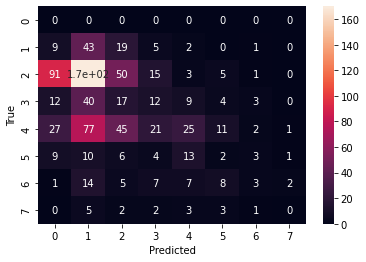

In [54]:
df_pcv_cm = pd.DataFrame(pcv_cm[:8, :8], range(8), range(8))
sn.heatmap(df_pcv_cm, annot=True)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

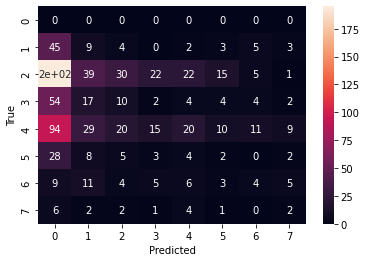

In [58]:
df_ocv_cm = pd.DataFrame(ocv_cm[:8, :8], range(8), range(8))
sn.heatmap(df_ocv_cm, annot=True)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [53]:
ocv_cm[:8, :8]

array([[  0,   0,   0,   0,   0,   0,   0,   0],
       [ 45,   9,   4,   0,   2,   3,   5,   3],
       [195,  39,  30,  22,  22,  15,   5,   1],
       [ 54,  17,  10,   2,   4,   4,   4,   2],
       [ 94,  29,  20,  15,  20,  10,  11,   9],
       [ 28,   8,   5,   3,   4,   2,   0,   2],
       [  9,  11,   4,   5,   6,   3,   4,   5],
       [  6,   2,   2,   1,   4,   1,   0,   2]])

## ML Evaluation
Data had to be batch saved to files and then loaded as attempting to calculate the data at once overloaded memory

In [9]:
preds = []
truth = []
with open("ml_preds.txt", "r") as pred_file:
    preds = pred_file.read().split('\n')[:-1]
with open("cor_ml_truth.txt", "r") as t_file:
    truth = t_file.read().split('\n')[:-1]

In [12]:
cv = lambda x: int(x) if x[0] != "-" else 0

In [14]:
preds = list(map(cv, preds))
truth = list(map(cv, truth))

ml_predictions = preds
X_val = ml_predictions # dummy
y_val = truth

In [16]:
ml_rep = classification_report(y_val,
                                ml_predictions,
                                target_names=[str(i) for i in range(0, 9)])

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this be

In [18]:
print("ML Classification Report")
print(ml_rep)

ML Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.22      0.08      0.11        79
           2       0.53      0.14      0.22       338
           3       0.13      0.77      0.23       102
           4       0.36      0.22      0.27       222
           5       1.00      0.02      0.04        54
           6       0.00      0.00      0.00        54
           7       0.00      0.00      0.00        21
           8       0.00      0.00      0.00        11

    accuracy                           0.21       881
   macro avg       0.25      0.14      0.10       881
weighted avg       0.39      0.21      0.19       881



In [19]:
ml_cm = confusion_matrix(y_val, ml_predictions)

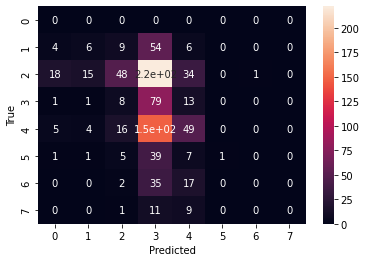

In [20]:
df_ml_cm = pd.DataFrame(ml_cm[:8, :8], range(8), range(8))
sn.heatmap(df_ml_cm, annot=True)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()